In [13]:
import pandas as pd
import numpy as np


from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier

from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform
import matplotlib.pyplot as plt

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [14]:
raw_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Train_raw.csv')
raw_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Test_raw.csv')

Adasyn_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Adasyn_train.csv')
Adasyn_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Adasyn_test.csv')

Nearmiss_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Nearmiss_train.csv')
Nearmiss_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Nearmiss_test.csv')

ROS_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/ROS_train.csv')
ROS_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/ROS_test.csv')

RUS_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/RUS_train.csv')
RUS_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/RUS_test.csv')

SMOTETomek_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/SMOTETomek_train.csv')
SMOTETomek_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/SMOTETomek_test.csv')

In [15]:
pip install neptune-client

In [16]:
import neptune

API_TOKEN='' #@param {type:"string"}

PROJEKT_NAME = 'DataWorkshop-Foundation/Predicting-cancellation-of-visit' 

neptune.init(
   api_token=API_TOKEN,
   project_qualified_name=PROJEKT_NAME
)

Project(DataWorkshop-Foundation/Predicting-cancellation-of-visit)

In [17]:
raw_train.head()

,PatientId,Gender,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,MonthBookingDate_0,MonthBookingDate_1,MonthBookingDate_2,MonthBookingDate_3,DayBookingDate_0,DayBookingDate_1,DayBookingDate_2,DayBookingDate_3,DayBookingDate_4,DayBookingDate_5,MonthAppointmentDate_0,MonthAppointmentDate_1,MonthAppointmentDate_2,DayAppointmentDate_0,DayAppointmentDate_1,DayAppointmentDate_2,DayAppointmentDate_3,DayAppointmentDate_4,DayAppointmentDate_5,HourOfDayBooking_0,DaysToAppointment,AppointmentWeekDay_0,AppointmentWeekDay_1,AppointmentWeekDay_2,AppointmentWeekDay_3,NoShow
0,4652519881919,0,8,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0
1,81431485833737,0,74,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,12,0,0,1,1,0
2,555956674526286,0,50,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,31,0,0,0,1,0
3,14559326134688,0,21,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,5,0,0,1,0,0
4,16796474433112,0,39,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,1,1,0,1,0,0,1,0,0,0,0,1,4,0,0,0,1,1


In [18]:
!pip install eli5
!pip install hyperopt

In [19]:
def get_feats(df):
    feats = df.select_dtypes(include=[np.int, np.float]).columns 
    return feats[ (feats != 'NoShow')].values

def get_X(df):
    return df[ get_feats(df) ].values

def get_y(df, target_var='NoShow'):
    return df[target_var].values

In [20]:
feats = ['PatientId',
 	'Gender',
  'Age', 	
  'Neighbourhood_0', 	
  'Neighbourhood_1', 	
  'Neighbourhood_2', 	
  'Neighbourhood_3',	
  'Neighbourhood_4', 	
  'Neighbourhood_5', 
  'Neighbourhood_6', 
  'Neighbourhood_7',	
  'Scholarship', 	
  'Hypertension', 	
  'Diabetes', 	
  'Alcoholism', 	
  'Handicap', 	
  'SMSReceived', 	
  'MonthBookingDate_0', 	
  'MonthBookingDate_1',	
  'MonthBookingDate_2', 	
  'MonthBookingDate_3', 	
  'DayBookingDate_0', 	
  'DayBookingDate_1',	
  'DayBookingDate_2',	
  'DayBookingDate_3', 	
  'DayBookingDate_4', 	
  'DayBookingDate_5', 	
  'MonthAppointmentDate_0', 	
  'MonthAppointmentDate_1', 	
  'MonthAppointmentDate_2', 	
  'DayAppointmentDate_0',	
  'DayAppointmentDate_1',	
  'DayAppointmentDate_2',	
  'DayAppointmentDate_3', 	
  'DayAppointmentDate_4',
  'DayAppointmentDate_5', 	
  'HourOfDayBooking_0', 	
  'DaysToAppointment', 	
  'AppointmentWeekDay_0', 	
  'AppointmentWeekDay_1', 	
  'AppointmentWeekDay_2', 	
  'AppointmentWeekDay_3']

In [21]:
X_raw = get_X(raw_train)
y_raw = get_y(raw_train)

In [22]:
len(feats)

42

In [23]:
space4rf = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'n_estimators': hp.choice('n_estimators', range(1,20)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])
}

In [24]:
def run_model(model):

  scores = cross_val_score(model, X_raw, y_raw, cv = 7, scoring='f1')
  
  return np.mean(scores), np.std(scores)

def hyperopt_train_test(params):
 

  print("Training with params: ")
  print(params)
  clf = RandomForestClassifier(**params)
  mean_f1, score_std = run_model(clf)
  print('loss: ',np.abs(mean_f1))
  return np.abs(mean_f1)

count = 0
best = 0

def f(params):
  f1 = hyperopt_train_test(params)
  return {'loss': -f1, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=300, trials=trials)
print('best:')
print(best)

Training with params: 
{'criterion': 'entropy', 'max_depth': 15, 'max_features': 4, 'n_estimators': 12}
loss: 
0.09484824564964457
Training with params: 
{'criterion': 'gini', 'max_depth': 2, 'max_features': 3, 'n_estimators': 11}
loss: 
0.0
Training with params: 
{'criterion': 'entropy', 'max_depth': 3, 'max_features': 2, 'n_estimators': 15}
loss: 
0.0
Training with params: 
{'criterion': 'gini', 'max_depth': 12, 'max_features': 3, 'n_estimators': 6}
loss: 
0.032320509422074144
Training with params: 
{'criterion': 'entropy', 'max_depth': 13, 'max_features': 2, 'n_estimators': 1}
loss: 
0.12368043051807857
Training with params: 
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 2, 'n_estimators': 9}
loss: 
0.0
Training with params: 
{'criterion': 'entropy', 'max_depth': 14, 'max_features': 1, 'n_estimators': 12}
loss: 
0.034264136754771184
Training with params: 
{'criterion': 'gini', 'max_depth': 5, 'max_features': 1, 'n_estimators': 5}
loss: 
0.0
Training with params: 
{'criter

In [25]:
best

{'criterion': 0, 'max_depth': 18, 'max_features': 2, 'n_estimators': 0}

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


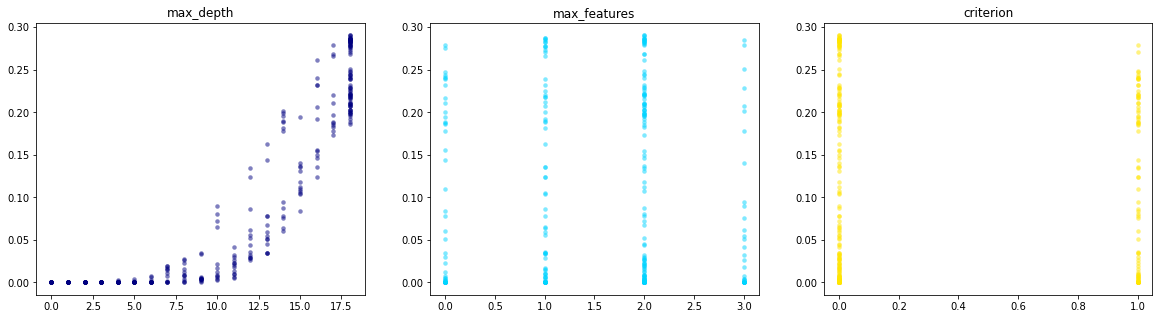

In [26]:
parameters = ['max_depth', 'max_features', 'criterion'] # decision tree
cols = len(parameters)

f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(20,5))

cmap = plt.cm.jet 

for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
   # xs, ys = zip(\*sorted(zip(xs, ys))
    ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)
    #axes[i].set_ylim([0.9,1.0])

In [27]:
if best['criterion'] == 0: 
  best['criterion'] = 'gini'
else:
  best['criterion'] = 'entropy'

In [28]:
best

{'criterion': 'gini', 'max_depth': 18, 'max_features': 2, 'n_estimators': 0}

In [29]:
clf = RandomForestClassifier(**best)

In [30]:
clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=0,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
def model(train, test, search, name, tags):
  
  #print(search.get_params())
  y_train = train["NoShow"]
  y_test = test["NoShow"]

  X_train = train.loc[:, train.columns != 'NoShow']
  X_test = test.loc[:, test.columns != 'NoShow']
                
  search = search.fit(X_train, y_train)

  #search.best_params_

  y_pred = search.predict(X_test)
  print(y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  print(' f1 ', f1_score(y_test, y_pred), '\n',
        'recall', recall_score(y_test, y_pred), '\n',
        'precision', precision_score(y_test, y_pred) )

  neptune.create_experiment(
      name=name
  )

  neptune.log_metric('accuracy', accuracy)
  neptune.log_metric('f1', f1_score(y_test, y_pred))
  neptune.log_metric('recall', recall_score(y_test, y_pred))
  neptune.log_metric('precision', precision_score(y_test, y_pred))
  neptune.append_tags(tags)
  neptune.append_tags([str(best),"Magdalena Cebula"])
  neptune.append_tags([str(feats)])
  neptune.append_tags([str(space4rf)])
  from sklearn.metrics import confusion_matrix

  conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
  print('Confusion matrix:\n', conf_mat)

  from matplotlib import pyplot as plt

  labels = ['Class 0', 'Class 1']
  fig = plt.figure()
  ax = fig.add_subplot()
  cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  plt.show()

  neptune.log_image('Confusion_matrix ' + name, fig)
  
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, search.predict(X_test))
  print(false_positive_rate, true_positive_rate, thresholds)


  roc_auc_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)
  neptune.log_metric('roc_auc', auc)
  fig = plt.figure()
  plt.plot(false_positive_rate,true_positive_rate,label="data 1, auc="+str(auc))
  plt.legend(loc=4)
  plt.show()
  neptune.log_image('ROC AUC ' + name, fig)
  neptune.stop()

In [32]:
model(raw_train, raw_test, clf, 'RandomForest', ['RandomForest', 'Raw'])

ValueError: ignored

In [33]:
X_neamiss = get_X(Nearmiss_train)
y_neamiss = get_y(Nearmiss_train)

def run_model(model):

  scores = cross_val_score(model, X_neamiss, y_neamiss, cv = 7, scoring='f1')
  
  return np.mean(scores), np.std(scores)

In [34]:
def hyperopt_train_test(params):
  print("Training with params: ")
  print(params)

  mean_mae, score_std = run_model(RandomForestClassifier(**params))
  print('loss: ',np.abs(mean_mae))
  return np.abs(mean_mae)

def f(params):
  f1 = hyperopt_train_test(params)
  return {'loss': -f1, 'status': STATUS_OK}
  
trials = Trials()

best = fmin(f, space4rf, algo=tpe.suggest, max_evals=300, trials=trials)

Training with params: 
{'criterion': 'gini', 'max_depth': 16, 'max_features': 4, 'n_estimators': 2}
loss: 
0.6718028218621358
Training with params: 
{'criterion': 'entropy', 'max_depth': 19, 'max_features': 1, 'n_estimators': 3}
loss: 
0.6861896371349323
Training with params: 
{'criterion': 'gini', 'max_depth': 18, 'max_features': 3, 'n_estimators': 8}
loss: 
0.7346232419288784
Training with params: 
{'criterion': 'gini', 'max_depth': 16, 'max_features': 3, 'n_estimators': 4}
loss: 
0.710980436623555
Training with params: 
{'criterion': 'gini', 'max_depth': 10, 'max_features': 3, 'n_estimators': 13}
loss: 
0.7488423927640457
Training with params: 
{'criterion': 'gini', 'max_depth': 9, 'max_features': 4, 'n_estimators': 14}
loss: 
0.7491200693204313
Training with params: 
{'criterion': 'entropy', 'max_depth': 7, 'max_features': 3, 'n_estimators': 9}
loss: 
0.7313696867589928
Training with params: 
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 4, 'n_estimators': 8}
loss: 
0.73

In [35]:
print('best:')
print(best)

best:
{'criterion': 0, 'max_depth': 11, 'max_features': 3, 'n_estimators': 18}


In [36]:
def criterion(best):
  print(best)
  if best['criterion'] == 0: 
    best['criterion'] = 'gini'
  else:
    best['criterion'] = 'entropy'
  print(best)
  clf = RandomForestClassifier(**best)
  print(clf)
  return clf

In [37]:
clf = criterion(best)

{'criterion': 0, 'max_depth': 11, 'max_features': 3, 'n_estimators': 18}
{'criterion': 'gini', 'max_depth': 11, 'max_features': 3, 'n_estimators': 18}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=18,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


[0 1 1 ... 1 1 0]
Accuracy: 77.73%
 f1  0.7686339054784859 
 recall 0.7399275690357627 
 precision 0.7996575342465754
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-120
Confusion matrix:
 [[3599  819]
 [1149 3269]]


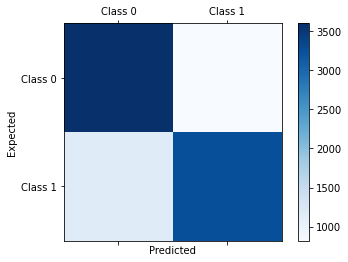

[0.       0.185378 1.      ] [0.         0.73992757 1.        ] [2 1 0]


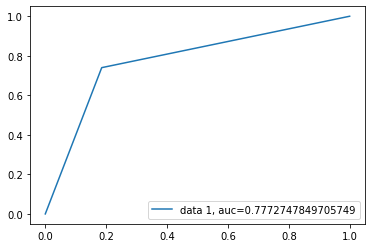

In [38]:
model(Nearmiss_train, Nearmiss_test,clf, "RandomForest", ['RandomForest', 'Nearmiss'])

In [39]:
X_ros = get_X(ROS_train)
y_ros = get_y(ROS_train)

def run_model(model):

  scores = cross_val_score(model, X_ros, y_ros, cv = 7, scoring='f1')
  
  return np.mean(scores), np.std(scores)

def hyperopt_train_test(params):
  print("Training with params: ")
  print(params)

  mean_mae, score_std = run_model(RandomForestClassifier(**params))
  print('loss: ',np.abs(mean_mae))
  return np.abs(mean_mae)

def f(params):
  f1 = hyperopt_train_test(params)
  return {'loss': -f1, 'status': STATUS_OK}
  
trials = Trials()

best = fmin(f, space4rf, algo=tpe.suggest, max_evals=300, trials=trials)

Training with params: 
{'criterion': 'gini', 'max_depth': 11, 'max_features': 3, 'n_estimators': 7}
loss: 
0.7394226507131446
Training with params: 
{'criterion': 'entropy', 'max_depth': 8, 'max_features': 1, 'n_estimators': 16}
loss: 
0.7029668158638539
Training with params: 
{'criterion': 'entropy', 'max_depth': 13, 'max_features': 3, 'n_estimators': 16}
loss: 
0.7703944900542385
Training with params: 
{'criterion': 'gini', 'max_depth': 14, 'max_features': 3, 'n_estimators': 3}
loss: 
0.7630948923685522
Training with params: 
{'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'n_estimators': 3}
loss: 
0.630095449491398
Training with params: 
{'criterion': 'gini', 'max_depth': 6, 'max_features': 1, 'n_estimators': 3}
loss: 
0.6415956199482787
Training with params: 
{'criterion': 'entropy', 'max_depth': 12, 'max_features': 2, 'n_estimators': 17}
loss: 
0.7516351828099976
Training with params: 
{'criterion': 'gini', 'max_depth': 19, 'max_features': 4, 'n_estimators': 11}
loss: 
0.

In [40]:
clf = criterion(best)

{'criterion': 0, 'max_depth': 18, 'max_features': 0, 'n_estimators': 16}
{'criterion': 'gini', 'max_depth': 18, 'max_features': 0, 'n_estimators': 16}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features=0,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=16,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [41]:
model(ROS_train, ROS_test,clf, "RandomForest", ['RandomForest', 'ROS'])

ValueError: ignored

In [42]:
X_rus = get_X(RUS_train)
y_rus = get_y(RUS_train)

def run_model(model):

  scores = cross_val_score(model, X_rus, y_rus, cv = 7, scoring='f1')
  
  return np.mean(scores), np.std(scores)

def hyperopt_train_test(params):
  print("Training with params: ")
  print(params)

  mean_mae, score_std = run_model(RandomForestClassifier(**params))
  print('loss: ',np.abs(mean_mae))
  return np.abs(mean_mae)


def f(params):
  f1 = hyperopt_train_test(params)
  return {'loss': -f1, 'status': STATUS_OK}
  
trials = Trials()

best = fmin(f, space4rf, algo=tpe.suggest, max_evals=300, trials=trials)

Training with params: 
{'criterion': 'gini', 'max_depth': 19, 'max_features': 1, 'n_estimators': 15}
loss: 
0.6631039600609385
Training with params: 
{'criterion': 'gini', 'max_depth': 9, 'max_features': 4, 'n_estimators': 8}
loss: 
0.7075596623755958
Training with params: 
{'criterion': 'entropy', 'max_depth': 2, 'max_features': 2, 'n_estimators': 7}
loss: 
0.6565156799005735
Training with params: 
{'criterion': 'entropy', 'max_depth': 16, 'max_features': 4, 'n_estimators': 19}
loss: 
0.6923031277059438
Training with params: 
{'criterion': 'gini', 'max_depth': 8, 'max_features': 1, 'n_estimators': 2}
loss: 
0.6320256218812147
Training with params: 
{'criterion': 'gini', 'max_depth': 15, 'max_features': 1, 'n_estimators': 19}
loss: 
0.6881889363096213
Training with params: 
{'criterion': 'gini', 'max_depth': 11, 'max_features': 4, 'n_estimators': 10}
loss: 
0.7053999682910203
Training with params: 
{'criterion': 'gini', 'max_depth': 1, 'max_features': 2, 'n_estimators': 4}
loss: 
0.592

In [43]:
best['max_depth']=2

In [44]:
clf = criterion(best)

{'criterion': 0, 'max_depth': 2, 'max_features': 3, 'n_estimators': 12}
{'criterion': 'gini', 'max_depth': 2, 'max_features': 3, 'n_estimators': 12}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=12,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


[1 1 0 ... 1 1 1]
Accuracy: 64.70%
 f1  0.7029806685077612 
 recall 0.8354459031235854 
 precision 0.6067729738615815
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-121
Confusion matrix:
 [[2026 2392]
 [ 727 3691]]


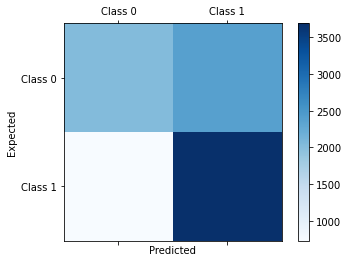

[0.         0.54142146 1.        ] [0.        0.8354459 1.       ] [2 1 0]


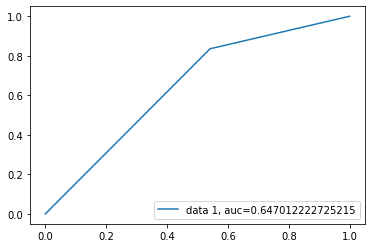

In [45]:
model(RUS_train, RUS_test,clf, "RandomForest", ['RandomForest', 'RUS'])

In [46]:
X_tomek = get_X(SMOTETomek_train)
y_tomek = get_y(SMOTETomek_train)

def run_model(model):

  scores = cross_val_score(model, X_tomek, y_tomek, cv = 7, scoring='f1')
  
  return np.mean(scores), np.std(scores)

def hyperopt_train_test(params):
  print("Training with params: ")
  print(params)

  mean_mae, score_std = run_model(RandomForestClassifier(**params))
  print('loss: ',np.abs(mean_mae))
  return np.abs(mean_mae)


def f(params):
  f1 = hyperopt_train_test(params)
  return {'loss': -f1, 'status': STATUS_OK}
  
trials = Trials()

best2 = fmin(f, space4rf, algo=tpe.suggest, max_evals=300, trials=trials)

Training with params: 
{'criterion': 'gini', 'max_depth': 5, 'max_features': 3, 'n_estimators': 13}
loss: 
0.7846298845812679
Training with params: 
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 4, 'n_estimators': 6}
loss: 
0.7787001544762889
Training with params: 
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 4, 'n_estimators': 12}
loss: 
0.8032277795833517
Training with params: 
{'criterion': 'entropy', 'max_depth': 7, 'max_features': 4, 'n_estimators': 18}
loss: 
0.7965413112229734
Training with params: 
{'criterion': 'gini', 'max_depth': 11, 'max_features': 3, 'n_estimators': 10}
loss: 
0.8069685629690068
Training with params: 
{'criterion': 'entropy', 'max_depth': 7, 'max_features': 3, 'n_estimators': 6}
loss: 
0.7742886624473048
Training with params: 
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 1, 'n_estimators': 5}
loss: 
0.7360129999844531
Training with params: 
{'criterion': 'entropy', 'max_depth': 14, 'max_features': 1, 'n_estimators': 4}
l

In [47]:
clf = criterion(best2)

{'criterion': 1, 'max_depth': 17, 'max_features': 2, 'n_estimators': 16}
{'criterion': 'entropy', 'max_depth': 17, 'max_features': 2, 'n_estimators': 16}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=17, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=16,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


[0 0 0 ... 1 1 1]
Accuracy: 86.40%
 f1  0.8566526282951178 
 recall 0.8126664693696359 
 precision 0.9056728232189973
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-122
Confusion matrix:
 [[12372  1144]
 [ 2532 10984]]


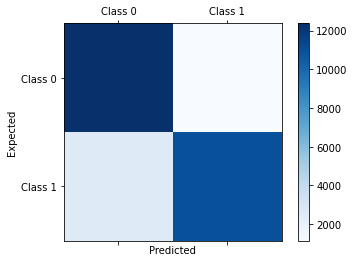

[0.         0.08464043 1.        ] [0.         0.81266647 1.        ] [2 1 0]


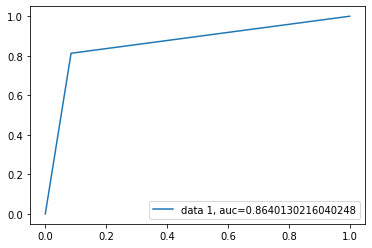

In [48]:
model(SMOTETomek_train, SMOTETomek_test,clf, "RandomForest", ['RandomForest', 'SMOTETomek'])

In [49]:
X_adasyn  = get_X(Adasyn_train)
y_adasyn = get_y(Adasyn_train)

def run_model(model):

  scores = cross_val_score(model, X_adasyn, y_adasyn, cv = 7, scoring='f1')
  
  return np.mean(scores), np.std(scores)

def hyperopt_train_test(params):
  print("Training with params: ")
  print(params)

  mean_mae, score_std = run_model(RandomForestClassifier(**params))
  print('loss: ',np.abs(mean_mae))
  return np.abs(mean_mae)


def f(params):
  f1 = hyperopt_train_test(params)
  return {'loss': -f1, 'status': STATUS_OK}
  
trials = Trials()

best2 = fmin(f, space4rf, algo=tpe.suggest, max_evals=300, trials=trials)

Training with params: 
{'criterion': 'gini', 'max_depth': 15, 'max_features': 2, 'n_estimators': 2}
loss: 
0.7560133816630957
Training with params: 
{'criterion': 'gini', 'max_depth': 17, 'max_features': 3, 'n_estimators': 1}
loss: 
0.7526101662135256
Training with params: 
{'criterion': 'gini', 'max_depth': 15, 'max_features': 2, 'n_estimators': 4}
loss: 
0.7709803981841531
Training with params: 
{'criterion': 'gini', 'max_depth': 16, 'max_features': 1, 'n_estimators': 10}
loss: 
0.7798095524209464
Training with params: 
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 2, 'n_estimators': 5}
loss: 
0.7636966477671487
Training with params: 
{'criterion': 'gini', 'max_depth': 11, 'max_features': 1, 'n_estimators': 8}
loss: 
0.7648122598835821
Training with params: 
{'criterion': 'entropy', 'max_depth': 2, 'max_features': 4, 'n_estimators': 7}
loss: 
0.7376140756590052
Training with params: 
{'criterion': 'gini', 'max_depth': 6, 'max_features': 1, 'n_estimators': 1}
loss: 
0.6582

In [50]:
clf = criterion(best2)

{'criterion': 0, 'max_depth': 18, 'max_features': 3, 'n_estimators': 13}
{'criterion': 'gini', 'max_depth': 18, 'max_features': 3, 'n_estimators': 13}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=13,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


[1 0 0 ... 1 1 1]
Accuracy: 84.73%
 f1  0.8391123439667129 
 recall 0.7964171245421245 
 precision 0.8866445775455588
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-123
Confusion matrix:
 [[15686  1779]
 [ 3557 13915]]


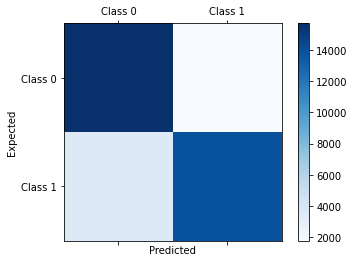

[0.         0.10186086 1.        ] [0.         0.79641712 1.        ] [2 1 0]


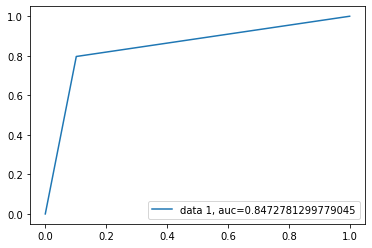

In [51]:
model(Adasyn_train, Adasyn_test,clf, "RandomForest", ['RandomForest', 'Adasyn'])